## Librerías necesarias

In [41]:
import pandas as pd
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
# import umap.umap_ as umap
from  bertopic import BERTopic
from transformers import pipeline
from bertopic.representation import TextGeneration
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import seaborn as sns

In [42]:
df_ar = pd.read_csv("../data/cleaned_data/arabe_limpio.csv", sep="\t", encoding="utf-8")
df_ar.rename(columns={"Texto": "text", "Capítulo": "capitulo", "Versículo": "versiculo"}, inplace=True)
print(df_ar["text"].head())

eng_q = pd.read_csv('../data/cleaned_data/cleaned_english_quran.txt', 
                    sep="|", 
                    names=["capitulo", "verso", "text"],
                    engine="python",
                    quoting=3, # Necesario para evitar problemas con las comillas en el texto en inglés.
                    header=None)

df_en = pd.DataFrame(eng_q)
print(df_en["text"].head())
df_en.head()

0    بسم الله الرحمن الرحيم
1     الحمد لله رب العالمين
2             الرحمن الرحيم
3            مالك يوم الدين
4    اياك نعبد واياك نستعين
Name: text, dtype: object
0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,text
0,1,1.0,in the name of allah the entirely merciful the...
1,1,2.0,all praise is due to allah lord of the worlds
2,1,3.0,the entirely merciful the especially merciful
3,1,4.0,sovereign of the day of recompense
4,1,5.0,it is you we worship and you we ask for help


Cargamos los modelos de fasttext obtenidos en el otro notebook

In [ ]:
# fasttext_arabe = fasttext.load_model("../src/modelos/fasttext_arabic_busqueda_semantica.bin")

In [ ]:
fasttext_english = fasttext.load_model("../src/modelos/fasttext_english_busqueda_seamantica.bin")

# Clustering de capítulos con HDBSCAN
Para este nuevo apartado, usaremos el mismo modelo de embeddings usado anteriormente (fasttext) utilizaremos UMAP para la reducción de dimensionalidad. Ya que supuestamente funciona mejor para embeddings que el PCA (usado antes) y usaremos el modelo de clustering HDBSCAN para visualizar los grupos de capítulos más similares en un espacio bidimensional.

En árabe primero:

In [ ]:
df_ft = df_ar.copy()
df_ft["text"] = df_ft["text"].str.strip()
df_ft = df_ft[df_ft["text"].str.contains(r"[\u0600-\u06FF]")]
df_ft["arab_embeddings"] = df_ft["text"].apply(lambda x: fasttext_arabe.get_sentence_vector(x))
print(df_ft.dtypes)
df_ft.head()

capitulo           float64
versiculo          float64
text                object
arab_embeddings     object
dtype: object


,capitulo,versiculo,text,arab_embeddings
0,1.0,1.0,بسم الله الرحمن الرحيم,"[0.051747173, 0.066025436, -0.12854035, -0.001..."
1,1.0,2.0,الحمد لله رب العالمين,"[0.027269885, 0.051695086, -0.1361687, -0.0273..."
2,1.0,3.0,الرحمن الرحيم,"[0.06481915, 0.054369055, -0.14707434, -0.0064..."
3,1.0,4.0,مالك يوم الدين,"[0.044288315, 0.067105874, -0.0988366, -0.0004..."
4,1.0,5.0,اياك نعبد واياك نستعين,"[0.016069604, 0.048078723, -0.14167276, -0.001..."


Ahora agrupamos los embeddings por capítulos en matrices y luego hacemos la media para poder obtener el embedding medio. Es algo similar a lo que haria fasttext pero en vez de hacer la media de los vectores de las palabras de una frase la hacemos por capítulos enteros.

In [ ]:
embeddings_cap_ar = (
    df_ft.groupby("capitulo")["arab_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_ar.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
print(embeddings_cap_ar.head(5))
print(len(embeddings_cap_ar["arab_embeddings"][0]))

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
   capitulo                                    arab_embeddings
0       1.0  [0.04252394, 0.052667428, -0.12788895, -0.0109...
1       2.0  [0.01152678, 0.05193744, -0.09761992, 0.007056...
2       3.0  [0.015129554, 0.053784143, -0.09595373, 0.0043...
3       4.0  [0.011246396, 0.05280654, -0.09196072, 0.00809...
4       5.0  [0.013732811, 0.05146736, -0.09750082, 0.00647...
300


Ahora reducimos la dimensionalidad de los vectores de 300 a 10 dimensiones gracias a UMAP

In [ ]:
# Ahora vamos a reducir su dimensionalidad con UMAP
X = np.vstack(embeddings_cap_ar["arab_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_ar = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_ar.fit_transform(X_scaled)

Agrupación con HDBSCAN

In [ ]:
hdbscan_ar = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_ar.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_ar["cluster"] = labels

Imprimimos los clusters que se han creado y los capítulos que no tienen cluster

In [ ]:
for c in sorted(embeddings_cap_ar["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_ar.loc[embeddings_cap_ar['cluster'] == c, 'capitulo'].tolist()}")

Capítulos sin cluster: [11.0, 14.0, 26.0, 28.0, 32.0, 38.0, 40.0, 44.0, 50.0, 55.0, 66.0, 75.0, 76.0, 82.0, 84.0, 88.0, 91.0, 93.0, 95.0, 96.0, 99.0, 101.0, 102.0, 105.0, 108.0, 111.0]
Cluster 0: [4.0, 33.0, 48.0, 65.0, 112.0]
Cluster 1: [16.0, 30.0, 39.0, 45.0]
Cluster 2: [8.0, 9.0, 47.0, 58.0, 59.0, 63.0, 98.0]
Cluster 3: [2.0, 3.0, 5.0, 22.0, 24.0, 49.0, 57.0, 60.0, 61.0, 62.0, 64.0, 103.0]
Cluster 4: [6.0, 10.0, 23.0, 29.0, 34.0, 41.0, 46.0]
Cluster 5: [21.0, 27.0, 36.0, 43.0]
Cluster 6: [13.0, 31.0, 35.0, 42.0, 85.0, 100.0, 110.0]
Cluster 7: [1.0, 67.0, 86.0, 97.0, 104.0, 106.0, 114.0]
Cluster 8: [74.0, 78.0, 79.0, 80.0, 89.0, 92.0]
Cluster 9: [53.0, 81.0, 87.0, 113.0]
Cluster 10: [17.0, 18.0, 25.0, 72.0, 90.0, 94.0]
Cluster 11: [12.0, 19.0, 20.0, 69.0, 71.0, 73.0, 109.0]
Cluster 12: [7.0, 15.0, 37.0, 51.0, 54.0, 68.0]
Cluster 13: [52.0, 56.0, 70.0, 77.0, 83.0, 107.0]


Mostramos los resultados:

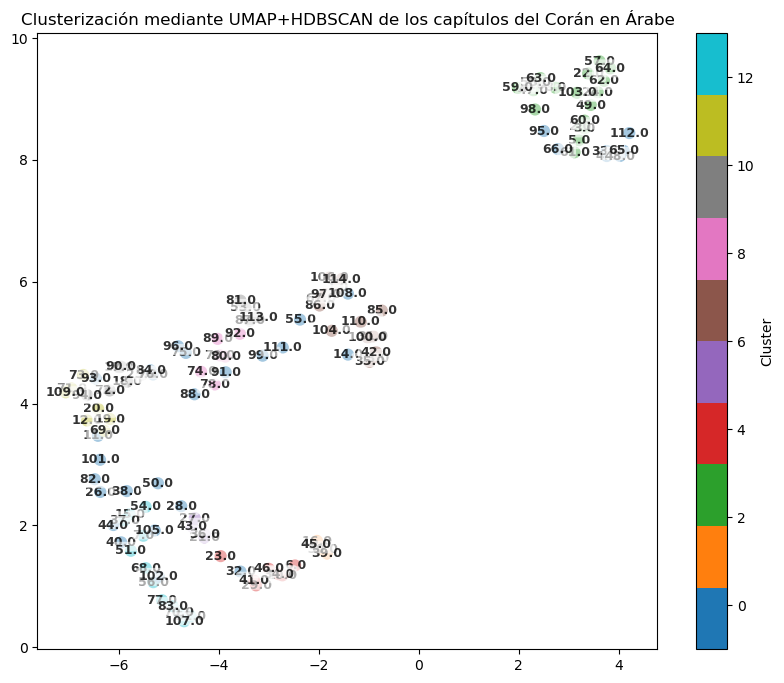

In [ ]:
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_ar = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_ar[:,0], X_2D_ar[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_ar["capitulo"]):
    plt.text(
        X_2D_ar[i, 0],
        X_2D_ar[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en Árabe")
plt.colorbar(label="Cluster")
plt.show()

En el caso de la clusterización de capítulos en inglés, lo haremos directamente ya que lo hemos explicado más detenidamente en el ejemplo árabe.

In [ ]:
df_en = df_en.dropna(subset=["text"])
df_en = df_en[df_en["text"].str.strip() != ""]
df_en["text"] = df_en["text"].astype(str)
print(df_en["text"].head())
df_en["eng_embeddings"] = df_en["text"].apply(lambda x: fasttext_english.get_sentence_vector(x))
df_en["capitulo"] = pd.to_numeric(df_en["capitulo"], errors="coerce").fillna(0).astype(int)
df_en["verso"] = pd.to_numeric(df_en["verso"], errors="coerce").fillna(0).astype(int)
df_en = df_en[df_en["verso"] != 0]
df_en.head()

0    in the name of allah the entirely merciful the...
1        all praise is due to allah lord of the worlds
2        the entirely merciful the especially merciful
3                   sovereign of the day of recompense
4         it is you we worship and you we ask for help
Name: text, dtype: object


,capitulo,verso,text,eng_embeddings
0,1,1,in the name of allah the entirely merciful the...,"[0.0083101755, 0.037431873, -0.052610807, -0.0..."
1,1,2,all praise is due to allah lord of the worlds,"[0.026291966, 0.094707906, -0.036288977, -0.02..."
2,1,3,the entirely merciful the especially merciful,"[-0.000697282, 0.016280154, -0.057597037, -0.0..."
3,1,4,sovereign of the day of recompense,"[0.009857434, 0.08513886, -0.06224656, -0.0500..."
4,1,5,it is you we worship and you we ask for help,"[0.0010185158, 0.046355397, -0.0045899125, -0...."


Hacemos el mismo proceso que con el arabe

Dimensiones de nuestro df con los embeddings agrupados por capitulos: (114, 2)
Capítulos sin cluster: [17, 30, 32, 38, 55, 56, 59, 73, 91, 93, 98, 105]
Cluster 0: [44, 50, 51, 54, 95, 106]
Cluster 1: [1, 13, 14, 22, 31, 35, 42, 57, 62, 64, 87, 92, 110, 112]
Cluster 2: [6, 10, 29, 34, 39, 40, 41, 45, 46, 67]
Cluster 3: [52, 70, 77, 82, 83, 102]
Cluster 4: [7, 15, 18, 21, 23, 25, 36, 37, 43, 68, 72]
Cluster 5: [2, 3, 5, 8, 9, 47, 49, 58, 60, 61, 63, 107]
Cluster 6: [4, 16, 24, 33, 48, 65, 66]
Cluster 7: [69, 74, 75, 79, 84, 86, 88, 99, 101, 103, 104]
Cluster 8: [85, 97, 100, 113, 114]
Cluster 9: [11, 26, 27, 28, 109]
Cluster 10: [12, 19, 20, 71, 94, 96, 108]
Cluster 11: [76, 78, 80, 90, 111]
Cluster 12: [53, 81, 89]


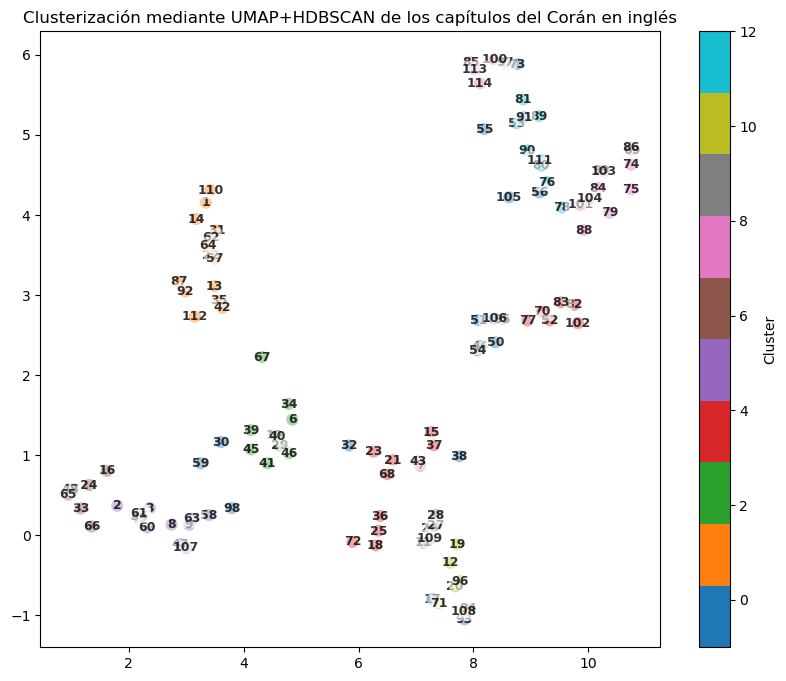

In [ ]:
embeddings_cap_eng = (
    df_en.groupby("capitulo")["eng_embeddings"].apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .reset_index()
)
print(f"Dimensiones de nuestro df con los embeddings agrupados por capitulos: {embeddings_cap_eng.shape}")
# 114 capítulos (filas) y 2 columnas (número del capítulo y los embeddings agrupados)
X = np.vstack(embeddings_cap_eng["eng_embeddings"].values) # Stackeamos verticalmente los embeddings por capítulo
X_scaled = StandardScaler().fit_transform(X) # Y escalamos

umap_reducer_eng = umap.UMAP(
    n_neighbors=5,
    min_dist=0.1, 
    n_components=10, # Lo dejaremos en 10 dimensiones para preservar mejor la información pero lo pasaremos a 2 después para una mejor visualización
    metric="cosine", # utilizaremos el cosine similarity como métrica de similitud
    random_state=42
)

X_umap = umap_reducer_eng.fit_transform(X_scaled)

hdbscan_eng = hdbscan.HDBSCAN(
    min_cluster_size = 3, # tamaño mínimo del cluster
    metric = "euclidean", # distancia euclidiana
    cluster_selection_epsilon = 0.05,
    cluster_selection_method = "leaf"
)

labels = hdbscan_eng.fit_predict(X_umap) # Labels predecidos por
embeddings_cap_eng["cluster"] = labels

for c in sorted(embeddings_cap_eng["cluster"].unique()):
    if c == -1: # No ha encontrado cluster el capítulo
        print(f"Capítulos sin cluster: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
    else:
        print(f"Cluster {c}: {embeddings_cap_eng.loc[embeddings_cap_eng['cluster'] == c, 'capitulo'].tolist()}")
        
reducer_2d = umap.UMAP(
    n_neighbors=5, 
    min_dist=0.1, 
    n_components=2, # ahora sí lo pasamos a 2 dimensiones
    metric="cosine", 
    random_state=42
)
X_2D_eng = reducer_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_2D_eng[:,0], X_2D_eng[:,1], c=labels, cmap="tab10", s=60)
for i, cap in enumerate(embeddings_cap_eng["capitulo"]):
    plt.text(
        X_2D_eng[i, 0],
        X_2D_eng[i, 1],
        str(cap),
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',       # color del texto
        alpha=0.8,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2')
    )
plt.title("Clusterización mediante UMAP+HDBSCAN de los capítulos del Corán en inglés")
plt.colorbar(label="Cluster")
plt.show()

Como comparación, podemos recalcar que aunque el número total de clusters entre idiomas sea similar, las distribuciones son totalmente diferentes. Al tratarse de embeddings creados mediante el mismo modelo pero diferente idioma, los embeddings están alineados en espacios vectoriales totalmente diferentes. Y por tanto, no son comparables. 

# Topic Modelling de los Capítulos del Corán
En esta segunda sección de este notebook, trabajaremos con BERTopic para intentar extraer información sobre los topics (o temas) que representan mejor los capítulos del texto sagrado. Aprovecharemos el modelo de embeddings fasttext (anteriormente utilizado) y el modelo UMAP para reducir la dimensión de los embeddings. Finalmente, intentaremos englobar cada tema con un label, simulando un título ficticio. Seguiremos el mismo proceso, profundizaremos en la explicación del desarrollo en árabe y lo haremos más directamente para nuestros ejemplos en inglés. 

Topic Modelling en árabe, pero tenemos que preparar el formato correcto primero:
- 'textos': con todos los textos (versículos) concatenados por capítulo (en el notebook correspondiente se usa 'abstracts')
- 'embeddings': los embeddings en forma de lista

In [ ]:
textos_ar = (
    df_ft.groupby("capitulo")["text"]
    .apply(lambda x: " ".join(x)) # concatenación
    .tolist()
)

embeddings_ar = np.stack(embeddings_cap_ar["arab_embeddings"].values)

print(embeddings_ar.shape)
print(embeddings_ar)

(114, 300)
[[ 0.04252394  0.05266743 -0.12788895 ... -0.00437724 -0.01318673
  -0.0212684 ]
 [ 0.01152678  0.05193744 -0.09761992 ... -0.00151375  0.02413788
  -0.04317744]
 [ 0.01512955  0.05378414 -0.09595373 ... -0.00103242  0.02048221
  -0.04236953]
 ...
 [ 0.01480489  0.05019181 -0.10857066 ...  0.0071005   0.01568219
  -0.0266838 ]
 [ 0.00689227  0.06461618 -0.09591396 ... -0.01014298  0.02594174
  -0.0372773 ]
 [ 0.02845711  0.04778448 -0.11958351 ... -0.00770382 -0.00405015
  -0.03125503]]


Aqui creamos el CountVecorizer para medir la importancia de las palabras por topic. Además hemos eliminado manualmente unas palabras (añadiendolas a las stopwords) que haciendo pruebas previas salian demasiado frecuentemente.

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer

# Stopwords en árabe, una lista arbitraria
stopwords_ar = list(stopwords.words('arabic'))

extra_stopwords_religiosas_ar = [
    "الله",     # Allah
    "محمد",     # Muhammad
    "رب",       # Lord
    "الله",     # God (igual que Allah)
    "قرآن",     # Quran
    "اسلام",    # Islam (sin hamza para evitar duplicados)
    "الاسلام",  # Islam (con artículo)
    "ربكم",     # your Lord
    "ربه",      # his Lord
    "ربهم",     # their Lord
    "يارب",     # oh Lord
]

stopwords_ar = stopwords_ar + extra_stopwords_religiosas_ar

# Vectorización de árabe
ar_vectorizer = CountVectorizer(stop_words=stopwords_ar)

ctfidf = ClassTfidfTransformer(
    reduce_frequent_words=True,
    seed_words=None,
    bm25_weighting=True, # Es interesante usarlo para datasets pequeños como puede ser el nuestro
)

In [ ]:
bertopic_ar = BERTopic(
    embedding_model = fasttext_arabe,
    umap_model = umap_reducer_ar,
    hdbscan_model = hdbscan_ar,
    vectorizer_model= ar_vectorizer,
    language = 'arabic',
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_ar, embeddings_ar)

2025-11-27 13:41:32,758 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-27 13:41:32,886 - BERTopic - Dimensionality - Completed ✓
2025-11-27 13:41:32,892 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-27 13:41:32,900 - BERTopic - Cluster - Completed ✓
2025-11-27 13:41:32,902 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-27 13:41:33,021 - BERTopic - Representation - Completed ✓


Ahora mostraremos los tópicos de forma interpretable enseñando las palabras más relevantes según c-TF-IDF.

In [ ]:
bertopic_ar.visualize_barchart(title="Visualización de Topics")

Como ahora mismo no podemos entender nada (por ahora no entendemos arabe), trabajaremos el ejemplo en inglés y usaremos funcionalidades para traducir y comparar los resultados en ambos idiomas.

Ejemplo en inglés, mismo procedimiento:

In [ ]:
textos_eng = (
    df_en.groupby("capitulo")["text"]
    .apply(lambda x: " ".join(x))
    .tolist()
)

embeddings_eng = np.stack(embeddings_cap_eng["eng_embeddings"].values)

# Para que no nos salgan stopwords como más predominantes
stopwords_en = list(stopwords.words("english"))

extra_stopwords_religiosas = [
    "allah", "muhammad", "god", "lord", "quran", "islam"
]

stopwords_en = stopwords_en + extra_stopwords_religiosas

en_vectorizer = CountVectorizer(stop_words=stopwords_en)

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_eng, embeddings_eng)

bertopic_eng.visualize_barchart(title="Visualización de Topics")

2025-11-27 13:41:35,726 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-27 13:41:35,862 - BERTopic - Dimensionality - Completed ✓
2025-11-27 13:41:35,864 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-27 13:41:35,871 - BERTopic - Cluster - Completed ✓
2025-11-27 13:41:35,871 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-27 13:41:35,975 - BERTopic - Representation - Completed ✓


Aquí podemos comprobar con que información conformados los objetos BERTopic.

In [ ]:
print(bertopic_eng.get_topic_info())

    Topic  Count                                     Name  \
0      -1     22           -1_made_created_merciful_earth   
1       0     11                   0_used_say_truth_signs   
2       1      9     1_messenger_fight_hearts_disbelieved   
3       2      9            2_favors_deny_deniers_warning   
4       3      7          3_pleasure_able_preventer_today   
5       4      7          4_dawn_mankind_retreating_stars   
6       5      6            5_loan_luqman_everyone_bounty   
7       6      6                   6_ever_women_men_wives   
8       7      6           7_joseph_father_brother_seduce   
9       8      6          8_wills_sends_protector_matters   
10      9      5                   9_gods_us_mention_said   
11     10      5                10_cup_mixture_man_silver   
12     11      4       11_scripture_fear_believed_whoever   
13     12      4                  12_ever_qur_way_destroy   
14     13      4  13_deliberated_inevitable_reality_saqar   
15     14      3        

Como vemos, los valores son casi los mismos para todos los topics.

Ahora apilaremos un par de rerankers para mejorar la representacion de los topic con palabras mas variadas y fieles al topic. Hacemos esto ya que las palabras pueden ser demasiado generales o muy repetitivas. Mediante esta capa extra conseguimos encontrar palabras/frases más cercanas semánticamente y aumentar la diversidad mientras se mantiene la relevancia.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

representaciones_originales_ar = bertopic_ar.get_topic_info().copy()
representaciones_originales_eng = bertopic_eng.get_topic_info().copy()

rep_model = [
    KeyBERTInspired(),
    MaximalMarginalRelevance(diversity=0.2)
]

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True,
    representation_model=rep_model
).fit(textos_eng, embeddings_eng)

bertopic_ar = BERTopic(
    embedding_model = fasttext_arabe,
    umap_model = umap_reducer_ar,
    hdbscan_model = hdbscan_ar,
    vectorizer_model= ar_vectorizer,
    language = 'arabic',
    representation_model=rep_model,
    ctfidf_model = ctfidf,
    verbose = True
).fit(textos_ar, embeddings_ar)

2025-11-27 13:41:38,088 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-27 13:41:38,233 - BERTopic - Dimensionality - Completed ✓
2025-11-27 13:41:38,233 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-27 13:41:38,233 - BERTopic - Cluster - Completed ✓
2025-11-27 13:41:38,242 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-27 13:41:48,209 - BERTopic - Representation - Completed ✓
2025-11-27 13:41:50,673 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-27 13:41:50,804 - BERTopic - Dimensionality - Completed ✓
2025-11-27 13:41:50,804 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-27 13:41:50,809 - BERTopic - Cluster - Completed ✓
2025-11-27 13:41:50,814 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-27 13:41:58,282 - BERTopic - Representation - Completed ✓


In [ ]:
bertopic_eng.visualize_topics(title="Visualización de Topics tras aplicar rerankers")

Como podemos comprobar las palabras que ha extraido son mas variadas y más representativas 

In [ ]:
bertopic_eng.visualize_barchart(title="Visualización de Topics tras aplicar rerankers")

In [ ]:
print(bertopic_eng.get_topic_info())
topic_rerankers_eng = bertopic_eng.get_topic_info()
topic_rerankers_ar = bertopic_ar.get_topic_info()

    Topic  Count                                            Name  \
0      -1     22                    -1_qur_worship_deity_solomon   
1       0     11                   0_qur_scripture_verses_praise   
2       1      9    1_disbelievers_prophet_disbelieved_believers   
3       2      9                   2_qur_torment_judgement_peace   
4       3      7               3_punishment_sinful_merciful_deny   
5       4      7                       4_qur_darkness_night_dawn   
6       5      6        5_verses_praise_praiseworthy_disbelieved   
7       6      6             6_prophet_hypocrites_marriage_wives   
8       7      6           7_moses_worship_suffer_interpretation   
9       8      6  8_praiseworthy_scriptures_creator_resurrection   
10      9      5              9_angels_worshippers_moses_worship   
11     10      5         10_disbeliever_sinner_purified_paradise   
12     11      4      11_believers_prophets_scripture_christians   
13     12      4                    12_qur_praye

## Generación de títulos para cada topic
Usaremos el modelo 'Flan-T5' para esto.

In [ ]:
generador_titulo = pipeline("text2text-generation", model="google/flan-t5-base")

Usamos un prompt few-shot para que el modelo tenga algo como referencia. El objetivo del prompt es que genere un label (una especie de titulo representativo) por cada topic.

In [ ]:
prompt = """
Generate a SHORT and ABSTRACT topic label (max 6 words).
Do NOT copy text from the documents.
Output ONLY the label (no punctuation, no quotes).

Examples:
DOCUMENTS: He created the heavens and the earth.
KEYWORDS: creation, power, universe
LABEL: Creation of the universe

DOCUMENTS: The righteous will be rewarded.
KEYWORDS: reward, paradise, righteousness
LABEL: Divine reward for righteousness

Now create a label for the following topic:

DOCUMENTS:
[DOCUMENTS]

KEYWORDS:
[KEYWORDS]

LABEL:
"""


Ahora simplemente creamos los topics finales con el modelo generativo que hemos seleccionado

In [ ]:
rep_model_final = [
    KeyBERTInspired(),
    MaximalMarginalRelevance(diversity=0.3),
    TextGeneration(
        generador_titulo,
        prompt=prompt,
        doc_length=50,
        tokenizer="whitespace"
    )
]

bertopic_eng = BERTopic(
    embedding_model = fasttext_english,
    umap_model = umap_reducer_eng,
    hdbscan_model = hdbscan_eng,
    vectorizer_model = en_vectorizer,
    ctfidf_model = ctfidf,
    verbose = True,
    representation_model=rep_model_final
).fit(textos_eng, embeddings_eng)

def diferentes_topics(modelo, topics_originales, topic_rerankers):
    nuevos_topics = modelo.get_topic_info()
    for i in range(len(nuevos_topics)):
        new_label = nuevos_topics.loc[i, "Name"]
        old_label = topics_originales.loc[i, "Name"] if i < len(topics_originales) else ""
        reranker_label = topic_rerankers.loc[i, "Name"] if i < len(topic_rerankers) else ""
        print(f"Topic {i}:\n  Original: {old_label}\n  Reranker: {reranker_label}\n  Nuevo: {new_label}\n")

2025-11-27 13:42:02,414 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-27 13:42:02,549 - BERTopic - Dimensionality - Completed ✓
2025-11-27 13:42:02,549 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-27 13:42:02,557 - BERTopic - Cluster - Completed ✓
2025-11-27 13:42:02,558 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 16/16 [00:33<00:00,  2.08s/it]
2025-11-27 13:42:42,221 - BERTopic - Representation - Completed ✓


In [ ]:
diferentes_topics(bertopic_eng, representaciones_originales_eng, topic_rerankers_eng)

Topic 0:
  Original: -1_made_created_merciful_earth
  Reranker: -1_qur_worship_deity_solomon
  Nuevo: -1_allah___

Topic 1:
  Original: 0_used_say_truth_signs
  Reranker: 0_qur_scripture_verses_praise
  Nuevo: 0_Qur an___

Topic 2:
  Original: 1_messenger_fight_hearts_disbelieved
  Reranker: 1_disbelievers_prophet_disbelieved_believers
  Nuevo: 1_allah___

Topic 3:
  Original: 2_favors_deny_deniers_warning
  Reranker: 2_qur_torment_judgement_peace
  Nuevo: 2_zaqqum___

Topic 4:
  Original: 3_pleasure_able_preventer_today
  Reranker: 3_punishment_sinful_merciful_deny
  Nuevo: 3_punishment___

Topic 5:
  Original: 4_dawn_mankind_retreating_stars
  Reranker: 4_qur_darkness_night_dawn
  Nuevo: 4_ablaze___

Topic 6:
  Original: 5_loan_luqman_everyone_bounty
  Reranker: 5_verses_praise_praiseworthy_disbelieved
  Nuevo: 5_Allah___

Topic 7:
  Original: 6_ever_women_men_wives
  Reranker: 6_prophet_hypocrites_marriage_wives
  Nuevo: 6_o allah, o allah, o allah, o allah___

Topic 8:
  Original: 

In [ ]:
diferentes_topics(bertopic_ar, representaciones_originales_ar, topic_rerankers_ar)

Topic 0:
  Original: -1_يومئذ_يوم_الرحيم_العزيز
  Reranker: -1_الكفار_الفلك_الرحمن_الارض
  Nuevo: -1_الكفار_الفلك_الرحمن_الارض

Topic 1:
  Original: 0_الكبري_يري_والليل_بالحسني
  Reranker: 0_الذكر_الذكري_الظن_الرحمن
  Nuevo: 0_الذكر_الذكري_الظن_الرحمن

Topic 2:
  Original: 1_يشاء_السماوات_شكور_الكبير
  Reranker: 1_المكر_ارسلناك_الكبير_اليك
  Nuevo: 1_المكر_ارسلناك_الكبير_اليك

Topic 3:
  Original: 2_احدا_سبيلا_وكان_كبيرا
  Reranker: 2_الكهف_الرحمن_فلن_وجعلنا
  Nuevo: 2_الكهف_الرحمن_فلن_وجعلنا

Topic 4:
  Original: 3_يوسف_قال_ابانا_نبيا
  Reranker: 3_الملك_الكيل_الرحمن_للرحمن
  Nuevo: 3_الملك_الكيل_الرحمن_للرحمن

Topic 5:
  Original: 4_والله_الكتاب_واذ_امنوا
  Reranker: 4_الكافرين_النار_الارض_اهل
  Nuevo: 4_الكافرين_النار_الارض_اهل

Topic 6:
  Original: 5_كذبوا_اصحاب_باياتنا_موسي
  Reranker: 5_ونصحت_ثله_الرجفه_الجنه
  Nuevo: 5_ونصحت_ثله_الرجفه_الجنه

Topic 7:
  Original: 6_ورسوله_والله_قلوبهم_سبيل
  Reranker: 6_الكفر_وللكافرين_العظيم_المشركين
  Nuevo: 6_الكفر_وللكافرين_العظيم_المشركين



Vamos a probar si con ollama obtenemos mejores resultados

In [ ]:
from ollama import generate
import ollama

response1 = ollama.generate(
    model='gemma3:4b',
    prompt=f'''Generate a SHORT and ABSTRACT topic label for each keyword and document (max 6 words).
            Do NOT copy text from the documents.
            Output ONLY the label (no punctuation, no quotes).
            Make sure the label captures the essence of both the documents and keywords as a kind of sentence.
            Take into account that the words given are in english. You have to make the sentence in english.

            Examples:
            DOCUMENTS: He created the heavens and the earth.
            KEYWORDS: creation, power, universe
            LABEL: Creation of the universe

            DOCUMENTS: The righteous will be rewarded.
            KEYWORDS: reward, paradise, righteousness
            LABEL: Divine reward for righteousness

            Now create a label for the following topics (a label for each keyword and document):

            DOCUMENTS:
            {topic_rerankers_eng["Name"]}

            KEYWORDS:
            {topic_rerankers_eng["Representation"]}

            LABEL:'''
)

print(response1.response)

Here are the labels, following your instructions:

1. Qur’an Worship of the Deity
2. Qur’an Verses of Praise and Belief
3. Disbelievers’ Disbelief and Believers’ Faith
4. Qur’an Torment, Judgement, and Divine Peace
5. Qur’an Darkness, Night, and Dawn’s Arrival
6. Verses of Praise for the Praiseworthy
7. Prophet, Hypocrites, and Marriages in Faith
8. Moses’ Worship and Suffering Interpretation
9. Praiseworthy Scriptures of Divine Creation
10. Angels, Worshippers, and Moses’ Worship
11. Disbeliever, Sinner, and Purification to Paradise
12. Believers, Prophets, and Christian Scriptures
13. Qur’an Prayer, Pharaoh, and Satan’s Ways
14. Resurrection, Qur’an, and Soul’s Reality
15. Moses, Pharaoh, and Believers’ Worship


In [ ]:

response2 = ollama.generate(
    model='gemma3:4b',
    prompt=f'''Generate a SHORT and ABSTRACT topic label for each keyword and document (max 6 words).
            Do NOT copy text from the documents.
            Output ONLY the label (no punctuation, no quotes).
            Make sure the label captures the essence of both the documents and keywords as a kind of sentence.
            Take into account that the words given are in arabic. You have to make the sentence in arabic and then translate it to english.

            Examples:
            DOCUMENTS: خلق السماوات والأرض.
            KEYWORDS: الخلق، القدرة، الكون
            LABEL: خلق الكون
            LABEL_ENG: Creation of the universe

            DOCUMENTS: سيتم مكافأة الصالحين.
            KEYWORDS: المكافأة، الجنة، الصلاح
            LABEL: المكافأة الإلهية للصالحين
            LABEL_ENG: Divine reward for righteousness

            Now create a label for the following topics with the corresponding translation in english (a label for each keyword and document):

            DOCUMENTS:
            {topic_rerankers_ar["Name"]}

            KEYWORDS:
            {topic_rerankers_ar["Representation"]}

            LABEL: LABEL_ENG:'''
)

print(response2.response)

Here's a generated label for each keyword and document, reflecting the essence of the Arabic text and its English translation:

**Labels and English Translations:**

0.  خلق الكون بالنار
    LABEL_ENG: Creation of universe with fire

1.  ذكر الله وشفاء الظن
    LABEL_ENG: Remembrance of God and dispelling doubt

2.  مكر الله ونجاته منك
    LABEL_ENG: God’s deception and his salvation from you

3.  الكهف ورحمة الله
    LABEL_ENG: The Cave and God’s mercy

4.  الملك والحكم الإلهي
    LABEL_ENG: Royal power and divine judgment

5.  الكافرون ونجاتهم في الجنة
    LABEL_ENG: Infidels and their salvation in paradise

6.  ونصحت ثلة من المسلمين
    LABEL_ENG: And a group of Muslims received guidance

7.  الكفر وشرور المشركين
    LABEL_ENG: Infidelity and the evils of disbelievers

8.  فضل الله بكل ما أنصافه
    LABEL_ENG: God’s bounty in all its forms

9.  الظلم والأرض قل
    LABEL_ENG: False suspicion and the Earth says

10. ذكر الله لمن كاد
    LABEL_ENG: Remembrance of God for the distressed

Ahora vamos a capturar todas esos topics y vamos a intentar ver como de cerca están entre sí.

In [67]:
import pandas as pd
import re

lines_ar = [line.strip() for line in response2.response.split("\n") if line.strip()]

lista_arabe = []
lista_ingles = []

# Patrones para identificar las líneas
num = re.compile(r'^\d+\.?\s*(.+)')
eng = re.compile(r'LABEL_ENG:\s*(.+)')

for line in lines_ar:
    match_eng = eng.search(line)
    if match_eng:
        lista_ingles.append(match_eng.group(1).strip())
        continue
    
    match_ar = num.match(line)
    if match_ar and "LABEL_ENG" not in line:
        lista_arabe.append(match_ar.group(1).strip())

df_arabe = pd.DataFrame({
    "Topic arabe": lista_arabe,
    "Traduccion ingles": lista_ingles
})

lines_en = [line.strip() for line in response1.response.split("\n") if line.strip()]

lista_ingles = []

for line in lines_en:
    match = num.match(line)
    if match:
        lista_ingles.append(match.group(1).strip())

df_ingles = pd.DataFrame({
    "Topic ingles": lista_ingles
})

display(df_arabe.head())
display(df_ingles.head())

,Topic arabe,Traduccion ingles
0,خلق الكون بالنار,Creation of universe with fire
1,ذكر الله وشفاء الظن,Remembrance of God and dispelling doubt
2,مكر الله ونجاته منك,God’s deception and his salvation from you
3,الكهف ورحمة الله,The Cave and God’s mercy
4,الملك والحكم الإلهي,Royal power and divine judgment


,Topic ingles
0,Qur’an Worship of the Deity
1,Qur’an Verses of Praise and Belief
2,Disbelievers’ Disbelief and Believers’ Faith
3,"Qur’an Torment, Judgement, and Divine Peace"
4,"Qur’an Darkness, Night, and Dawn’s Arrival"


,ID topic ingles,Topic ingles,ID mejor match arabe,Mejor match traducido arabe,Similarity Score
1,1,Qur’an Verses of Praise and Belief,7,Infidelity and the evils of disbelievers,0.956880
5,5,Verses of Praise for the Praiseworthy,16,Forgive criminals in the sleeves,0.920711
10,10,"Disbeliever, Sinner, and Purification to Paradise",7,Infidelity and the evils of disbelievers,0.915299
8,8,Praiseworthy Scriptures of Divine Creation,0,Creation of universe with fire,0.907977
0,0,Qur’an Worship of the Deity,11,Remembrance of God and the kingdom of ants,0.903431
6,6,"Prophet, Hypocrites, and Marriages in Faith",5,Infidels and their salvation in paradise,0.899342
7,7,Moses’ Worship and Suffering Interpretation,14,Angels and their praise of Muslims,0.890297
12,12,"Qur’an Prayer, Pharaoh, and Satan’s Ways",11,Remembrance of God and the kingdom of ants,0.888657
4,4,"Qur’an Darkness, Night, and Dawn’s Arrival",4,Royal power and divine judgment,0.882766
13,13,"Resurrection, Qur’an, and Soul’s Reality",4,Royal power and divine judgment,0.867560


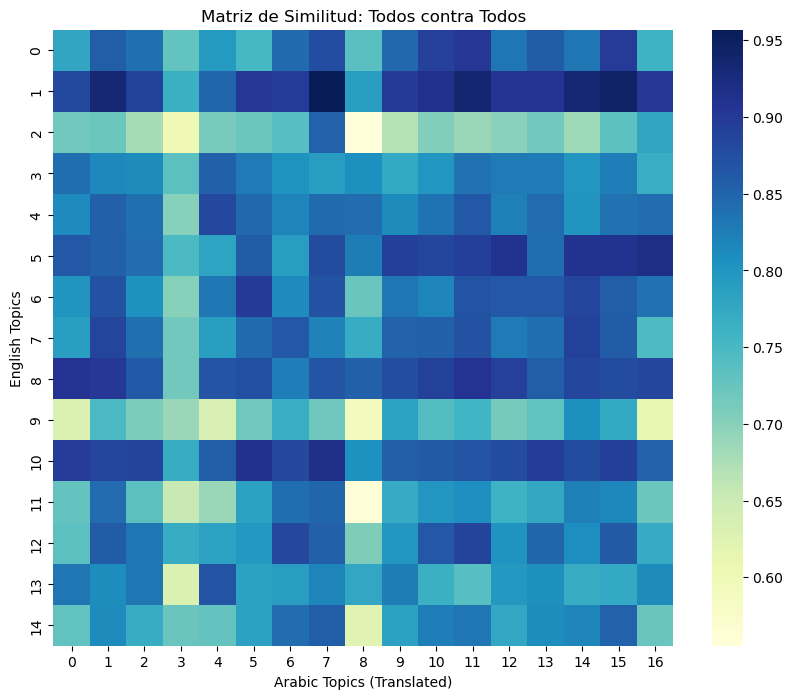

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = fasttext_english
vecs_english = [model.get_sentence_vector(str(x)) for x in df_ingles["Topic ingles"]]
vecs_translated = [model.get_sentence_vector(str(x)) for x in df_arabe["Traduccion ingles"]]

similarity_matrix = cosine_similarity(vecs_english, vecs_translated)

results = []
for i, row_sims in enumerate(similarity_matrix):
    best_match_idx = np.argmax(row_sims)
    best_score = row_sims[best_match_idx]
    
    results.append({
        "ID topic ingles": i,
        "Topic ingles": df_ingles.iloc[i]["Topic ingles"],
        "ID mejor match arabe": best_match_idx,
        "Mejor match traducido arabe": df_arabe.iloc[best_match_idx]["Traduccion ingles"],
        "Similarity Score": best_score
    })

df_matches = pd.DataFrame(results)
df_matches = df_matches.sort_values(by="Similarity Score", ascending=False)
display(df_matches)
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap="YlGnBu", annot=False)
plt.xlabel("Topics arabes")
plt.ylabel("Topics ingles")
plt.title("Matriz de Similitud: Todos contra Todos")
plt.show()